In [0]:
!wget "http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/night2day.tar.gz"

--2019-08-12 19:13:54--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/night2day.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.189.73
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.189.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2063695642 (1.9G) [application/x-gzip]
Saving to: ‘night2day.tar.gz’

night2day.tar.gz    100%[===================>]   1.92G  1.18MB/s    in 38m 8s  

2019-08-12 19:52:02 (881 KB/s) - ‘night2day.tar.gz’ saved [2063695642/2063695642]



In [0]:
!tar xvzf night2day.tar.gz

night2day/
night2day/train/
night2day/train/43_3730_to_3733.jpg
night2day/train/100_8399_to_8397.jpg
night2day/train/100_8399_to_8400.jpg
night2day/train/100_8399_to_8404.jpg
night2day/train/100_8399_to_8405.jpg
night2day/train/100_8399_to_8406.jpg
night2day/train/100_8399_to_8408.jpg
night2day/train/100_8399_to_8412.jpg
night2day/train/100_8399_to_8413.jpg
night2day/train/100_8399_to_8414.jpg
night2day/train/100_8399_to_8415.jpg
night2day/train/100_8399_to_8416.jpg
night2day/train/100_8399_to_8417.jpg
night2day/train/100_8399_to_8420.jpg
night2day/train/100_8399_to_8422.jpg
night2day/train/100_8399_to_8424.jpg
night2day/train/1_50_to_19.jpg
night2day/train/1_50_to_2.jpg
night2day/train/1_50_to_21.jpg
night2day/train/1_50_to_22.jpg
night2day/train/1_50_to_23.jpg
night2day/train/1_50_to_24.jpg
night2day/train/1_50_to_25.jpg
night2day/train/1_50_to_26.jpg
night2day/train/1_50_to_27.jpg
night2day/train/1_50_to_28.jpg
night2day/train/1_50_to_31.jpg
night2day/train/1_50_to_32.jpg
night2day/

In [0]:
import os
print(len(os.listdir("night2day/val")))

10


In [0]:
# load, split and scale the maps dataset ready for training
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed

# load all images in a directory into memory
def load_images(path, size=(256,512)):
	src_list, tar_list = list(), list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# split into satellite and map
		sat_img, map_img = pixels[:, :256], pixels[:, 256:]
		src_list.append(sat_img)
		tar_list.append(map_img)
	return [asarray(src_list), asarray(tar_list)]

# dataset path
path = 'night2day/test/'
# load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)
# save as compressed numpy array
filename = 'night2day_256.npz'
savez_compressed(filename, src_images, tar_images)
print('Saved dataset: ', filename)


Using TensorFlow backend.


Loaded:  (2287, 256, 256, 3) (2287, 256, 256, 3)
Saved dataset:  night2day_256.npz


In [0]:
# load the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the face dataset
data = load('night2day_256.npz')
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

In [0]:
# example of pix2pix gan for satellite to map image-to-image translation
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot

# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	print(n_steps)
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)

# load image data
dataset = load_real_samples('night2day_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
night2day_d_model = define_discriminator(image_shape)
night2day_g_model = define_generator(image_shape)
# define the composite model
night2day_gan_model = define_gan(night2day_g_model, night2day_d_model, image_shape)
# train model


Using TensorFlow backend.
W0812 21:22:11.884154 140066335410048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0812 21:22:11.910226 140066335410048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0812 21:22:11.921131 140066335410048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0812 21:22:11.965734 140066335410048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0812 21

Loaded (2287, 256, 256, 3) (2287, 256, 256, 3)


W0812 21:22:14.619561 140066335410048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0812 21:22:15.060615 140066335410048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0812 21:22:15.072803 140066335410048 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0812 21:22:15.622982 140066335410048 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling d

In [0]:
train(night2day_d_model, night2day_g_model, night2day_gan_model, dataset,n_epochs=10)

22870


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, d1[0.605] d2[0.528] g[53.101]
>2, d1[0.739] d2[0.992] g[62.435]
>3, d1[0.479] d2[0.803] g[37.126]
>4, d1[0.490] d2[0.822] g[33.602]
>5, d1[0.541] d2[0.528] g[55.105]
>6, d1[0.454] d2[0.457] g[33.317]
>7, d1[0.476] d2[0.429] g[51.493]
>8, d1[0.557] d2[0.438] g[41.430]
>9, d1[0.498] d2[0.428] g[28.341]
>10, d1[0.486] d2[0.411] g[21.134]
>11, d1[0.445] d2[0.565] g[29.151]
>12, d1[0.436] d2[0.416] g[36.019]
>13, d1[0.415] d2[0.381] g[37.135]
>14, d1[0.339] d2[0.327] g[42.369]
>15, d1[0.406] d2[0.364] g[35.325]
>16, d1[0.383] d2[0.380] g[25.133]
>17, d1[0.366] d2[0.410] g[40.602]
>18, d1[0.429] d2[0.318] g[35.836]
>19, d1[0.443] d2[0.355] g[47.159]
>20, d1[0.387] d2[0.336] g[38.542]
>21, d1[0.302] d2[0.450] g[30.462]
>22, d1[0.421] d2[0.321] g[56.986]
>23, d1[0.475] d2[0.332] g[22.069]
>24, d1[0.357] d2[0.354] g[32.385]
>25, d1[0.357] d2[0.331] g[35.690]
>26, d1[0.398] d2[0.323] g[18.946]
>27, d1[0.306] d2[0.337] g[32.972]
>28, d1[0.405] d2[0.354] g[33.998]
>29, d1[0.298] d2[0.321] g[30

In [0]:
night2day_d_model.save("night2day_d_model.h5")
night2day_g_model.save("night2day_g_model.h5") 
night2day_gan_model.save("night2day_gan_model.h5")

In [0]:
!curl --upload-file ./night2day_d_model.h5 https://transfer.sh/night2day_d_model.h5

https://transfer.sh/ZPvFH/night2day_d_model.h5

In [0]:
!curl --upload-file ./night2day_g_model.h5 https://transfer.sh/night2day_g_model.h5

https://transfer.sh/ncPG4/night2day_g_model.h5

In [0]:
!curl --upload-file ./night2day_gan_model.h5 https://transfer.sh/night2day_gan_model.h5

https://transfer.sh/10rQbF/night2day_gan_model.h5

In [0]:
!wget https://transfer.sh/ZPvFH/night2day_dmodel.h5

--2019-08-14 08:01:11--  https://transfer.sh/ZPvFH/night2day_dmodel.h5
Resolving transfer.sh (transfer.sh)... 144.76.136.153
Connecting to transfer.sh (transfer.sh)|144.76.136.153|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2019-08-14 08:01:13 ERROR 404: Not Found.



In [0]:
!wget https://transfer.sh/ncPG4/night2day_g_model.h5

--2019-08-14 08:01:38--  https://transfer.sh/ncPG4/night2day_g_model.h5
Resolving transfer.sh (transfer.sh)... 144.76.136.153
Connecting to transfer.sh (transfer.sh)|144.76.136.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 217866512 (208M) [application/octet-stream]
Saving to: ‘night2day_g_model.h5’

night2day_g_model.h 100%[===================>] 207.77M  25.3MB/s    in 8.7s    

2019-08-14 08:01:48 (23.8 MB/s) - ‘night2day_g_model.h5’ saved [217866512/217866512]



In [0]:
!wget https://transfer.sh/m3Kss/gan_model.h5

--2019-08-11 07:26:51--  https://transfer.sh/m3Kss/gan_model.h5
Resolving transfer.sh (transfer.sh)... 144.76.136.153
Connecting to transfer.sh (transfer.sh)|144.76.136.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681146048 (650M) [application/octet-stream]
Saving to: ‘gan_model.h5’

gan_model.h5        100%[===================>] 649.59M  13.4MB/s    in 35s     

2019-08-11 07:27:27 (18.6 MB/s) - ‘gan_model.h5’ saved [681146048/681146048]



In [0]:
###################
##### TEST ########
###################


Loaded (1096, 256, 256, 3) (1096, 256, 256, 3)


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[42]


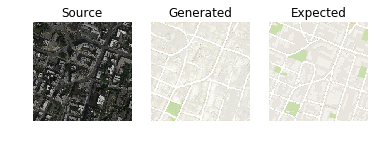

<class 'numpy.ndarray'> (1, 256, 256, 3) (1, 256, 256, 3)


In [0]:
# example of loading a pix2pix model and using it for image to image translation
from keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint

# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated', 'Expected']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, 3, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# show title
		pyplot.title(titles[i])
	pyplot.show()

# load dataset
[X1, X2] = load_real_samples('maps_256.npz')
print('Loaded', X1.shape, X2.shape)
# load model
model = load_model('g_model.h5')
# select random example
ix = randint(0, len(X1), 1)
print(ix)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)
print(type(src_image), gen_image.shape, tar_image.shape)

In [0]:
src_image.shape

(1, 256, 256, 3)

In [0]:
# load, split and scale the maps dataset ready for training
import os
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.models import load_model
from matplotlib import pyplot as plt
import numpy as np
from numpy import vstack
import time


model = load_model('night2day_g_model.h5')



W0814 08:03:04.389722 140081009915776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0814 08:03:04.437641 140081009915776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0814 08:03:04.486479 140081009915776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0814 08:03:04.488832 140081009915776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0814 08:03:04.489836 14008100991

In [0]:

filename="./14_1148_to_1163.jpg"
size=(256,512)
pixels = load_img(filename, target_size=size)

# convert to numpy array
pixels = img_to_array(pixels)
# split into satellite and map
sat_img, map_img = pixels[:, :256], pixels[:, 256:]
sat_img = (sat_img - 127.5) / 127.5
map_img = (map_img - 127.5) / 127.5

input_image=[]
input_image.append(sat_img)
input_image=np.array(input_image)

print(input_image.shape)

t1=time.time()
gen_image=model.predict(input_image)
t2=time.time()


(1, 256, 256, 3)


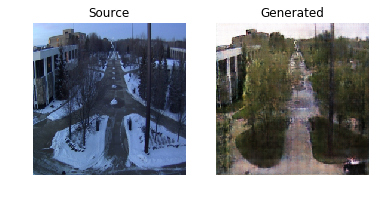

In [0]:
# plot source, generated and target images
from matplotlib import pyplot
def show_images(src_img, gen_img):
	images = vstack((src_img, gen_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, 2, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# show title
		pyplot.title(titles[i])
	pyplot.show()

show_images(input_image,gen_image)

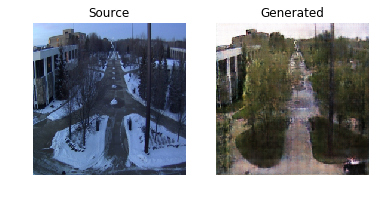

In [0]:
    show_images(input_image,gen_image)

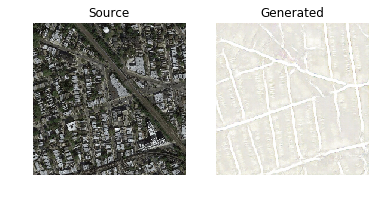

In [0]:
show_images(input_image,gen_image)